In [1]:
import re
import json

import requests
import scrapy

import numpy as np

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
#nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4']) #download all the necessary packages
#nltk.download()

In [4]:
df = pd.read_csv('data/anime_with_synopsis.csv', index_col='MAL_ID', dtype=str)

In [5]:
pattern = re.compile(r'[^a-z0-9]+')

In [6]:
df.sypnopsis = df.sypnopsis.apply(lambda x: pattern.sub(' ', str(x).lower()))
df.sypnopsis = df.sypnopsis.apply(word_tokenize)

In [7]:
stop_words = stopwords.words('english')

In [8]:
df.sypnopsis = df.sypnopsis.apply(lambda sypnopsis: [word for word in sypnopsis if word not in stop_words])

In [9]:
lemmatizer = WordNetLemmatizer()

def lemmatize(token, pos='nvars'):
    for p in pos:
        lemma = lemmatizer.lemmatize(token, pos=p)
        if lemma != token:
            return lemma
    return token

In [10]:
df.sypnopsis = df.sypnopsis.apply(lambda words: [lemmatize(w) for w in words])

In [11]:
df.sypnopsis = df.sypnopsis.apply(lambda words: ' '.join(words))

In [12]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.75)

In [13]:
vec_data = tfidf.fit_transform(df.sypnopsis)

In [14]:
cos_sim = cosine_similarity(vec_data)
cos_sim = pd.DataFrame(cos_sim, index=df.index, columns=df.index)

In [15]:
cos_sim.index

Int64Index([    1,     5,     6,     7,     8,    15,    16,    17,    18,
               19,
            ...
            48456, 48466, 48470, 48471, 48480, 48481, 48483, 48488, 48491,
            48492],
           dtype='int64', name='MAL_ID', length=16214)

In [17]:
cos_sim

MAL_ID,1,5,6,7,8,15,16,17,18,19,...,48456,48466,48470,48471,48480,48481,48483,48488,48491,48492
MAL_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.271822,0.046490,0.031206,0.012403,0.027094,0.012781,0.023231,0.025364,0.015156,...,0.000000,0.006996,0.017145,0.008457,0.000000,0.000000,0.020457,0.0,0.010168,0.052264
5,0.271822,1.000000,0.044624,0.033449,0.007127,0.031560,0.038316,0.018972,0.017261,0.020030,...,0.000000,0.018414,0.016502,0.003167,0.000000,0.000000,0.020811,0.0,0.000000,0.013498
6,0.046490,0.044624,1.000000,0.000000,0.010547,0.005848,0.009973,0.008917,0.000000,0.026231,...,0.000000,0.016119,0.025739,0.009053,0.013714,0.013714,0.011155,0.0,0.000000,0.006880
7,0.031206,0.033449,0.000000,1.000000,0.009356,0.031251,0.010091,0.033333,0.015767,0.016795,...,0.025568,0.059329,0.022586,0.016189,0.000000,0.000000,0.018762,0.0,0.000000,0.008187
8,0.012403,0.007127,0.010547,0.009356,1.000000,0.055794,0.016077,0.023808,0.007991,0.014273,...,0.000000,0.042606,0.010340,0.005697,0.000000,0.000000,0.020261,0.0,0.000000,0.019289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,0.000000,0.000000,0.013714,0.000000,0.000000,0.012348,0.000000,0.000000,0.034163,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.000000
48483,0.020457,0.020811,0.011155,0.018762,0.020261,0.040134,0.024941,0.009443,0.028785,0.045575,...,0.000000,0.000000,0.039570,0.031597,0.000000,0.000000,1.000000,0.0,0.000000,0.010758
48488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


In [16]:
cos_sim.to_hdf('models/cos_sim.hdf', 'df', mode='w')

In [3]:
df = pd.read_hdf('models/cos_sim.hdf', 'df')

In [54]:
row = df.loc[1]
row = row[(row < 1)&(row > .01)]

In [55]:
index = row.index.values
weights = row.values
weights = weights / weights.sum()

In [56]:
idx = np.random.choice(index, p=weights, size=5)
idx

array([ 5833,  1302, 28013, 16608, 30998])

In [57]:
row[idx]

MAL_ID
5833     0.061608
1302     0.067860
28013    0.044230
16608    0.038672
30998    0.027077
Name: 1, dtype: float64

In [58]:
index

array([    5,     6,     7, ..., 48483, 48491, 48492])

In [59]:
weights

array([1.43927303e-03, 2.59509385e-04, 1.63606286e-04, ...,
       1.07060307e-04, 5.33038616e-05, 2.73913032e-04])

In [98]:
q = np.percentile(row, 100 * (1-0.005))

In [100]:
100 * (1-0.005)

99.5

In [99]:
row[row>q].size

38

In [78]:
row = row.sort_values(ascending=False)
row

MAL_ID
5        0.274653
4240     0.202382
36357    0.169663
4037     0.161624
1287     0.151076
           ...   
8525     0.010005
39725    0.010002
6431     0.010001
37112    0.010001
30721    0.010000
Name: 1, Length: 7587, dtype: float64

In [80]:
import matplotlib.pyplot as plt

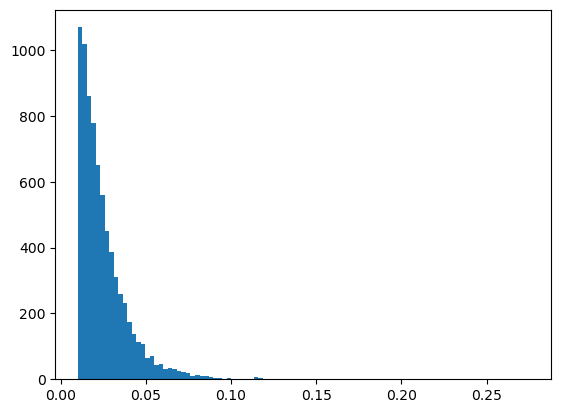

In [83]:
plt.hist(row, bins=100);

In [85]:
row[row > .1].size

29

In [86]:
(row > .1).mean()

0.003822327665744036

In [61]:
row[index].sort_values(ascending=False)

MAL_ID
5        0.274653
4240     0.202382
36357    0.169663
4037     0.161624
1287     0.151076
           ...   
8525     0.010005
39725    0.010002
6431     0.010001
37112    0.010001
30721    0.010000
Name: 1, Length: 7587, dtype: float64

In [15]:
@np.vectorize
def get_data(anime_id):

    url = f'https://myanimelist.net/anime/{anime_id}'

    request = requests.get(url)
    html = request.content.decode('utf-8')
    sel = scrapy.Selector(text=html)

    xpath = '//p[@itemprop="description"]/text()'
    sinopse = ''.join(sel.xpath(xpath).extract())

    xpath = '//img[@itemprop="image"]/@data-src'
    img_url = sel.xpath(xpath).extract_first()

    xpath = '//a[@class="iframe js-fancybox-video video-unit promotion"]/@href'
    teaser_url = sel.xpath(xpath).extract_first()

    return {
        'url': url,
        'sinopse': sinopse,
        'image': img_url,
        'teaser': teaser_url
    }

In [16]:
get_data(idx)

array([{'url': 'https://myanimelist.net/anime/2884', 'sinopse': 'After the world ran out of all traditional energy sources, only one remained—human excrement. To encourage citizens to produce as much waste as possible, the government implants a chip in the anus at birth, which provides citizens with "juicybars" every time it detects defecation. Juicybars are highly addictive narcotics that sometimes transform their users into mutant blue dwarfs with extreme constipation. These mutant addicts make up the "Diaper Gang," those who live underground and are focused on trying to obtain juicybars.\r\n\r\nAachi and Ssipak are two small-time crooks who steal and sell juicybars to make it on the streets. When they meet a beautiful woman who has the anal chips of every Diaper Gang member implanted in her, producing dozens of juicybars with every dump, Aachi and Ssipak strike it rich. However, with both the government and the Diaper Gang on their tails, the two struggle to protect their newfound r